In [35]:
import pandas as pd
import numpy as np
import os
import pickle
import xgboost as xgb
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/processed_files/df_datos_completos.csv')

In [4]:
df.fixture_id

0       203877
1       203878
2       203879
3       203880
4       203881
         ...  
5332    878166
5333    878633
5334    878640
5335    878170
5336    878632
Name: fixture_id, Length: 5337, dtype: int64

In [5]:
odds = pd.read_csv('../data/raw_files/cuotas/SP2-2012.csv')

In [6]:
odds

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,SP2,17/08/12,Barcelona B,Almeria,4.0,5.0,A,2.0,2.0,D,...,2.02,18.0,-0.25,1.97,1.93,1.97,1.93,2.29,3.43,3.43
1,SP2,17/08/12,Mirandes,Huesca,0.0,1.0,A,0.0,1.0,A,...,1.58,17.0,-0.50,1.93,1.87,2.05,1.99,1.89,3.43,4.98
2,SP2,17/08/12,Villarreal,Real Madrid B,2.0,1.0,H,1.0,1.0,D,...,1.88,17.0,-0.50,1.94,1.90,2.00,1.96,1.88,3.63,4.66
3,SP2,18/08/12,Girona,Sabadell,0.0,0.0,D,0.0,0.0,D,...,1.60,17.0,-0.25,1.82,1.79,2.14,2.08,2.14,3.38,3.84
4,SP2,18/08/12,Lugo,Hercules,1.0,0.0,H,1.0,0.0,H,...,1.71,18.0,0.00,1.95,1.91,2.00,1.93,3.42,3.25,2.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,SP2,08/06/13,Villarreal,Almeria,1.0,0.0,H,0.0,0.0,D,...,2.26,19.0,-0.50,1.88,1.85,2.05,2.01,1.95,3.51,4.38
460,SP2,08/06/13,Xerez,Barcelona B,2.0,1.0,H,1.0,1.0,D,...,2.79,19.0,0.50,1.87,1.82,2.09,2.04,3.16,3.67,2.29
461,SP2,09/06/13,Numancia,Cordoba,1.0,0.0,H,0.0,0.0,D,...,1.95,16.0,-0.50,2.14,2.07,1.87,1.79,1.88,3.81,4.37
462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def procesado_cuotas(file_names, df_ids):
    equivalencia_nombres = {
            'Celta':'Celta Vigo',
            'Mallorca':'Mallorca',
            'Sevilla': 'Sevilla',
            'Ath Bilbao': 'Athletic Club',
            'Barcelona':'Barcelona',
            'Levante':'Levante',
            'Real Madrid': 'Real Madrid',
            'La Coruna': 'Deportivo La Coruna',
            'Vallecano': 'Rayo Vallecano',
            'Zaragoza': 'Zaragoza',
            'Betis': 'Real Betis',
            'Espanol':'Espanyol',
            'Malaga':'Malaga',
            'Sociedad':'Real Sociedad',
            'Getafe':'Getafe',
            'Granada':'Granada CF',
            'Osasuna':'Osasuna',
            'Valencia':'Valencia',
            'Ath Madrid':'Atletico Madrid',
            'Valladolid':'Valladolid',
            'Barcelona B':'Barcelona B',
            'Mirandes':'Mirandes',
            'Villarreal':'Villarreal',
            'Girona':'Girona',
            'Lugo':'Lugo',
            'Xerez':'Xerez',
            'Alcorcon':'Alcorcon',
            'Elche':'Elche',
            'Numancia':'Numancia',
            'Santander':'Racing Santander',
            'Murcia':'Real Murcia',
            'Almeria':'Almeria',
            'Guadalajara':'Guadalajara',
            'Huesca':'Huesca',
            'Las Palmas':'Las Palmas',
            'Ponferradina':'Ponferradina',
            'Real Madrid B':'Real Madrid II',
            'Recreativo':'Recreativo Huelva',
            'Sabadell':'Sabadell',
            'Sp Gijon':'Sporting Gijon',
            'Cordoba':'Cordoba',
            'Hercules':'Hércules',
            'Jaen':'Real Jaén',
            'Alaves':'Alaves',
            'Eibar':'Eibar',
            'Tenerife':'Tenerife',
            'Albacete':'Albacete',
            'Leganes':'Leganes',
            'Llagostera':'Llagostera',
            'Gimnastic':'Gimnastic',
            'Oviedo':'Oviedo',
            'Ath Bilbao B':'Athletic Club II',
            'Sevilla B':'Sevilla Atletico',
            'Reus Deportiu':'Reus',
            'Cadiz':'Cadiz',
            'UCAM Murcia':'Ucam Murcia',
            'Lorca':'Lorca',
            'Leonesa':'Cultural Leonesa',
            'Extremadura UD':'Extremadura',
            'Rayo Majadahonda':'Rayo Majadahonda',
            'Fuenlabrada':'Fuenlabrada',
            'Castellon':'Castellón',
            'Cartagena':'FC Cartagena',
            'Logrones':'UD Logroñés',
            'Sociedad B':'Real Sociedad II',
            'Ibiza':'Ibiza',
            'Amorebieta':'Amorebieta',
            'Burgos':'Burgos',
            'Villarreal B':'Villarreal II',
            'Andorra':'FC Andorra'
        }
    
    def select_columns_and_add_season(df, file_name):
        # Extraer año del nombre del archivo
        year = file_name.split('-')[1][:4]

        # Crear un diccionario que contenga los nombres de los equipos como claves y sus IDs como valores
        equipo_id = {}
        for index, row in df_ids.iterrows():
            equipo_id[row['equipo_jugador']] = row['id_equipo']

        # Reemplazar los nombres de los equipos por sus IDs correspondientes utilizando el diccionario de equivalencias y el diccionario equipo_id
        df['HomeTeam'] = df['HomeTeam'].map(equivalencia_nombres).map(equipo_id)
        df['AwayTeam'] = df['AwayTeam'].map(equivalencia_nombres).map(equipo_id)

        # Seleccionar columnas requeridas
        df_selected = df[['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']]

        # Añadir columna "season" con el año extraído
        df_selected['season'] = int(year)

        # Eliminar filas con valores NaN
        df_selected.dropna(inplace=True)

        return df_selected

    # Lista para guardar los dataframes procesados
    processed_dfs = []

    # Iterar sobre los nombres de archivo
    for file_name in file_names:
        # Leer archivo CSV en un dataframe
        df = pd.read_csv(file_name)

        # Aplicar la función select_columns_and_add_season y renombrar las columnas
        df_processed = select_columns_and_add_season(df, file_name).rename(columns={'B365H': 'odd_1', 'B365D': 'odd_x', 'B365A': 'odd_2'})

        # Agregar el dataframe procesado a la lista
        processed_dfs.append(df_processed)

    # Concatenar todos los dataframes procesados en uno solo
    final_df = pd.concat(processed_dfs, ignore_index=True)
    final_df = final_df.dropna(how='any')
    final_df['HomeTeam'] = final_df['HomeTeam'].astype(int)
    final_df['AwayTeam'] = final_df['AwayTeam'].astype(int)

    return final_df


In [8]:
def ruta_cuotas():
    return [
    '../data/raw_files/cuotas/SP1-2012.csv',
    '../data/raw_files/cuotas/SP2-2012.csv',
    '../data/raw_files/cuotas/SP1-2013.csv',
    '../data/raw_files/cuotas/SP2-2013.csv',
    '../data/raw_files/cuotas/SP1-2014.csv',
    '../data/raw_files/cuotas/SP2-2014.csv',
    '../data/raw_files/cuotas/SP1-2015.csv',
    '../data/raw_files/cuotas/SP2-2015.csv',
    '../data/raw_files/cuotas/SP1-2016.csv',
    '../data/raw_files/cuotas/SP2-2016.csv',
    '../data/raw_files/cuotas/SP1-2017.csv',
    '../data/raw_files/cuotas/SP2-2017.csv',
    '../data/raw_files/cuotas/SP1-2018.csv',
    '../data/raw_files/cuotas/SP2-2018.csv',
    '../data/raw_files/cuotas/SP1-2019.csv',
    '../data/raw_files/cuotas/SP2-2019.csv',
    '../data/raw_files/cuotas/SP1-2020.csv',
    '../data/raw_files/cuotas/SP2-2020.csv',
    '../data/raw_files/cuotas/SP1-2021.csv',
    '../data/raw_files/cuotas/SP2-2021.csv',
    '../data/raw_files/cuotas/SP1-2022.csv',
    '../data/raw_files/cuotas/SP2-2022.csv'
]

In [9]:
df_dicc_equipos = pd.read_csv('../data/raw_files/df_dicc_equipos.csv')
file_names = [
    '../data/raw_files/cuotas/SP1-2012.csv',
    '../data/raw_files/cuotas/SP2-2012.csv',
    '../data/raw_files/cuotas/SP1-2013.csv',
    '../data/raw_files/cuotas/SP2-2013.csv',
    '../data/raw_files/cuotas/SP1-2014.csv',
    '../data/raw_files/cuotas/SP2-2014.csv',
    '../data/raw_files/cuotas/SP1-2015.csv',
    '../data/raw_files/cuotas/SP2-2015.csv',
    '../data/raw_files/cuotas/SP1-2016.csv',
    '../data/raw_files/cuotas/SP2-2016.csv',
    '../data/raw_files/cuotas/SP1-2017.csv',
    '../data/raw_files/cuotas/SP2-2017.csv',
    '../data/raw_files/cuotas/SP1-2018.csv',
    '../data/raw_files/cuotas/SP2-2018.csv',
    '../data/raw_files/cuotas/SP1-2019.csv',
    '../data/raw_files/cuotas/SP2-2019.csv',
    '../data/raw_files/cuotas/SP1-2020.csv',
    '../data/raw_files/cuotas/SP2-2020.csv',
    '../data/raw_files/cuotas/SP1-2021.csv',
    '../data/raw_files/cuotas/SP2-2021.csv',
    '../data/raw_files/cuotas/SP1-2022.csv',
    '../data/raw_files/cuotas/SP2-2022.csv'
]

# Procesar archivos y concatenar resultados
df_final = procesado_cuotas(file_names, df_dicc_equipos)

# Guardar el dataframe resultante en un archivo CSV
#df_final.to_csv('df_cuotas_completo', index=False)

C:\Users\gonve\AppData\Local\Temp\ipykernel_45936\840935780.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['season'] = int(year)
C:\Users\gonve\AppData\Local\Temp\ipykernel_45936\840935780.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(inplace=True)
C:\Users\gonve\AppData\Local\Temp\ipykernel_45936\840935780.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [10]:
def creacion_df_final(df_lesionados, df_alineaciones, df_datos_partidos, df_estadisticas, df_cuotas):
        '''Esta función hace un merge de todos los datos sacados anteriormente'''
        #Comenzamos la unión de dataframes, empezando por los datos de partidos y estadísticas
        df_final = pd.merge(df_datos_partidos, df_estadisticas, on='fixture_id', how='left')
        
        #Elimino las filas en las que la API no me devuelve un solo valor(ha pasado)
        rows_with_all_missing = df_final.loc[:, 'shots_on_goal_local':].isna().all(axis=1)
        df_final = df_final[~rows_with_all_missing]
        
        #Unimos el df resultante con el de lesionados
        df_final = pd.merge(df_final,df_lesionados, on='fixture_id', how = 'left')
        #Relleno los missings con 0, ya que significa que en esos partidos no ha habido lesionados
        df_final = df_final.fillna(0)
        
        #Unimos el df_final con el de alineaciones, que es el que faltaría.
        df_final = pd.merge(df_final, df_alineaciones, on='fixture_id', how='left')
        #Relleno los missings con 0, ya que significa que en esos partidos no habría participado ese jugador
        df_final = df_final.fillna(0)
        df_final = df_final.reset_index()

        df_cuotas.rename(columns={'HomeTeam': 'id_equipo_local', 'AwayTeam': 'id_equipo_visitante'}, inplace=True)
        df_final = pd.merge(df_final, df_cuotas, on=['id_equipo_local', 'id_equipo_visitante', 'season'], how='left')
        
        df_final = df_final.reset_index()
        
        #Para agilizar tiempos en métedos que necesitan esta tabla para usarse, ya que tarda un poco en ejecutarse.
        df_final.to_csv('df_partidos_completo.csv', index=False)
        
        return df_final

def procesado_lesionados(df):
        '''Coge el dataframe de lesionados y le aplica un OneHotEncoder, pero sin usar la librería. Para tener en cuenta que jugadores
        han participado en el encuentro de inicio o no. Es representativo ya que la no presencia de un jugador puede afectar en el resultado
        de un partido'''
        #Añade una fila de 1 para identificar que ese jugador ha estado lesionado en algún momento
            
        df['lesionados'] = pd.Series(np.ones(len(df)), index=df.index)
        
        
        df_lesionados_id = df[['fixture_id', 'id_lesionado', 'lesionados']]
        
        #Elimino fila si hay missings en la columna de id_jugador_titular
        df_lesionados_id = df_lesionados_id.dropna(subset=['id_lesionado'])
        
        #Pivota la tabla para convertir en una variable cada jugador. Para los partidos que el jugador no ha estado lesionado,
        #se rellenará con un '0'. Dejo el índice de la forma correcta.
        df_lesionados_id = df_lesionados_id.pivot( index= 'fixture_id', 
                                                columns = 'id_lesionado', 
                                                values = 'lesionados').fillna(0).reset_index()
        df_lesionados_id.columns.name = None
        
        #Transformo los valores '1' y '0' a int.
        df_lesionados_id.iloc[:,1:] =df_lesionados_id.iloc[:,1:].astype(int)
        
        #Añado al nombre de las variables de los id de jugadores 'les-' para identificar que es la variable de lesionados.
        df_lesionados_id = df_lesionados_id.rename(columns={col: f'les-{col}' for col in df_lesionados_id.iloc[:,1:]})
        
        return df_lesionados_id


def procesado_titulares(df):
    '''Coge el dataframe de alineaciones y le aplica un OneHotEncoder, pero sin usar la librería. Para tener en cuenta que jugadores
    han participado en el encuentro de inicio o no. Es representativo ya que la no presencia de un jugador puede afectar en el resultado
    de un partido'''    

    #Añade una fila de 1 para identificar que ese jugador ha estado lesionado en algún momento
    df['titular'] = pd.Series(np.ones(len(df)), index=df.index)
    df_alineaciones_id = df[['fixture_id', 'id_jugador_titular', 'titular']]
    #Elimino fila si hay missings en la columna de id_jugador_titular
    df_alineaciones_id = df_alineaciones_id.dropna(subset=['id_jugador_titular'])
    #Pivota la tabla para convertir en una variable cada jugador. Para los partidos que el jugador no ha estado lesionado,
    #se rellenará con un '0'. Dejo el índice de la forma correcta.
    df_alineaciones_id = df_alineaciones_id.pivot( index= 'fixture_id', 
                                            columns = 'id_jugador_titular', 
                                            values = 'titular').fillna(0).reset_index()
    df_alineaciones_id.columns.name = None
    
    #Me cargo un jugador con id nulo (hay que revisarlo después del procesado)
    df_alineaciones_id = df_alineaciones_id.drop(df_alineaciones_id.columns[1], axis=1)
    
    #Transformo los valores '1' y '0' a int.
    df_alineaciones_id.iloc[:,1:]=df_alineaciones_id.iloc[:,1:].astype(int)
    
    #Añado al nombre de las variables de los id de jugadores 'les-' para identificar que es la variable de lesionados.
    df_alineaciones_id = df_alineaciones_id.rename(columns={col: f'titu-{col}' for col in df_alineaciones_id.iloc[:,1:]})
    
    return df_alineaciones_id

def procesado_estadisticas(df):
    '''Procesado de todas las estadisticas que se han extraido, y que ocurren dentro de un partido.'''
    #Elimino las filas en las que la API no me devuelve un solo valor(ha pasado)
    rows_with_all_missing = df.iloc[:, :-1].isna().all(axis=1)
    df = df[~rows_with_all_missing]
    #Renombro dos columnas mal nombradas (no es el dato que dice la columna)
    df = df.rename(columns={'pass_precision_local': 'total_pass_local',
                            'pass_precision_away': 'total_pass_away',
                        'fixture_id_2': 'fixture_id'})
    #Transformo los datos de posesion a float para poder usarlos de forma más sencilla
    df['ball_possession_local'] = df['ball_possession_local'].str.replace('%','').astype(float)
    df['ball_possession_away'] = df['ball_possession_away'].str.replace('%', '').astype(float)

    df['ball_possession_local'] = df['ball_possession_local']/100
    df['ball_possession_away'] = df['ball_possession_away']/100
    # Convertir columna a tipo numérico. Esto es porque en las tarjetas amarillas habia datos erroneos (con porcntaje)
    df['yellow_cards_local'] = pd.to_numeric(df['yellow_cards_local'], errors='coerce')
    df['yellow_cards_away'] = pd.to_numeric(df['yellow_cards_away'], errors='coerce')

    # Filtro filas con NaN en la columna en cuestión y las elimino
    rows_with_nan = df['yellow_cards_local'].isna() | df['yellow_cards_away'].isna()
    df = df[~rows_with_nan]
    #Cambio los missings por 0, ya que cuando el valor es 0 la api devuelve null.
    df.fillna(0, inplace = True)
    #Cambio todas las columnas que quiero que sean número entero para trabajar mejor con ellos
    cols_to_int = ['shots_on_goal_local', 'shots_on_goal_away', 'shots_off_goal_local', 'shots_off_goal_away', 
            'total_shots_local', 'total_shots_away', 'blocked_shots_local', 'blocked_shots_away', 
            'shots_insidebox_local', 'shots_insidebox_away', 'shots_outsidebox_local', 'shots_outsidebox_away', 
            'fouls_local', 'fouls_away', 'corners_local', 'corners_away', 'offsides_local', 'offsides_away', 
            'yellow_cards_local', 'yellow_cards_away', 'red_cards_local', 'red_cards_away', 'goalkeeper_saves_local', 
            'goalkeeper_saves_away', 'total_pass_local', 'total_pass_away']
    df[cols_to_int] = df[cols_to_int].astype(int)
    
    return df
    
def procesado_datos_generales(df):
    '''Eliminación de missings en los goles (ya que si no hay goles lo considera como missing), y cambiar el tipo de los goles
    a favor/en contra'''
    #Sustituimos los missings por 0, ya que esos missings significa que ha habido 0 goles
    df['goles_descanso_local'] = df['goles_descanso_local'].fillna(0)
    df['goles_descanso_visitante'] = df['goles_descanso_visitante'].fillna(0)
    #Cambio el tipo de float a int, ya que no puede haber goles decimales
    df['goles_descanso_local'] = df['goles_descanso_local'].astype(int)
    df['goles_descanso_visitante'] = df['goles_descanso_visitante'].astype(int)
    
    return df

def ruta_cuotas():
    return [
    '../data/raw_files/cuotas/SP1-2012.csv',
    '../data/raw_files/cuotas/SP2-2012.csv',
    '../data/raw_files/cuotas/SP1-2013.csv',
    '../data/raw_files/cuotas/SP2-2013.csv',
    '../data/raw_files/cuotas/SP1-2014.csv',
    '../data/raw_files/cuotas/SP2-2014.csv',
    '../data/raw_files/cuotas/SP1-2015.csv',
    '../data/raw_files/cuotas/SP2-2015.csv',
    '../data/raw_files/cuotas/SP1-2016.csv',
    '../data/raw_files/cuotas/SP2-2016.csv',
    '../data/raw_files/cuotas/SP1-2017.csv',
    '../data/raw_files/cuotas/SP2-2017.csv',
    '../data/raw_files/cuotas/SP1-2018.csv',
    '../data/raw_files/cuotas/SP2-2018.csv',
    '../data/raw_files/cuotas/SP1-2019.csv',
    '../data/raw_files/cuotas/SP2-2019.csv',
    '../data/raw_files/cuotas/SP1-2020.csv',
    '../data/raw_files/cuotas/SP2-2020.csv',
    '../data/raw_files/cuotas/SP1-2021.csv',
    '../data/raw_files/cuotas/SP2-2021.csv',
    '../data/raw_files/cuotas/SP1-2022.csv',
    '../data/raw_files/cuotas/SP2-2022.csv'
]

def procesado_cuotas(file_names, df_ids):
    equivalencia_nombres = {
            'Celta':'Celta Vigo',
            'Mallorca':'Mallorca',
            'Sevilla': 'Sevilla',
            'Ath Bilbao': 'Athletic Club',
            'Barcelona':'Barcelona',
            'Levante':'Levante',
            'Real Madrid': 'Real Madrid',
            'La Coruna': 'Deportivo La Coruna',
            'Vallecano': 'Rayo Vallecano',
            'Zaragoza': 'Zaragoza',
            'Betis': 'Real Betis',
            'Espanol':'Espanyol',
            'Malaga':'Malaga',
            'Sociedad':'Real Sociedad',
            'Getafe':'Getafe',
            'Granada':'Granada CF',
            'Osasuna':'Osasuna',
            'Valencia':'Valencia',
            'Ath Madrid':'Atletico Madrid',
            'Valladolid':'Valladolid',
            'Barcelona B':'Barcelona B',
            'Mirandes':'Mirandes',
            'Villarreal':'Villarreal',
            'Girona':'Girona',
            'Lugo':'Lugo',
            'Xerez':'Xerez',
            'Alcorcon':'Alcorcon',
            'Elche':'Elche',
            'Numancia':'Numancia',
            'Santander':'Racing Santander',
            'Murcia':'Real Murcia',
            'Almeria':'Almeria',
            'Guadalajara':'Guadalajara',
            'Huesca':'Huesca',
            'Las Palmas':'Las Palmas',
            'Ponferradina':'Ponferradina',
            'Real Madrid B':'Real Madrid II',
            'Recreativo':'Recreativo Huelva',
            'Sabadell':'Sabadell',
            'Sp Gijon':'Sporting Gijon',
            'Cordoba':'Cordoba',
            'Hercules':'Hércules',
            'Jaen':'Real Jaén',
            'Alaves':'Alaves',
            'Eibar':'Eibar',
            'Tenerife':'Tenerife',
            'Albacete':'Albacete',
            'Leganes':'Leganes',
            'Llagostera':'Llagostera',
            'Gimnastic':'Gimnastic',
            'Oviedo':'Oviedo',
            'Ath Bilbao B':'Athletic Club II',
            'Sevilla B':'Sevilla Atletico',
            'Reus Deportiu':'Reus',
            'Cadiz':'Cadiz',
            'UCAM Murcia':'Ucam Murcia',
            'Lorca':'Lorca',
            'Leonesa':'Cultural Leonesa',
            'Extremadura UD':'Extremadura',
            'Rayo Majadahonda':'Rayo Majadahonda',
            'Fuenlabrada':'Fuenlabrada',
            'Castellon':'Castellón',
            'Cartagena':'FC Cartagena',
            'Logrones':'UD Logroñés',
            'Sociedad B':'Real Sociedad II',
            'Ibiza':'Ibiza',
            'Amorebieta':'Amorebieta',
            'Burgos':'Burgos',
            'Villarreal B':'Villarreal II',
            'Andorra':'FC Andorra'
        }
    
    def select_columns_and_add_season(df, file_name):
        # Extraer año del nombre del archivo
        year = file_name.split('-')[1][:4]

        # Crear un diccionario que contenga los nombres de los equipos como claves y sus IDs como valores
        equipo_id = {}
        for index, row in df_ids.iterrows():
            equipo_id[row['equipo_jugador']] = row['id_equipo']

        # Reemplazar los nombres de los equipos por sus IDs correspondientes utilizando el diccionario de equivalencias y el diccionario equipo_id
        df['HomeTeam'] = df['HomeTeam'].map(equivalencia_nombres).map(equipo_id)
        df['AwayTeam'] = df['AwayTeam'].map(equivalencia_nombres).map(equipo_id)

        # Seleccionar columnas requeridas
        df_selected = df[['HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']]

        # Añadir columna "season" con el año extraído
        df_selected['season'] = int(year)

        # Eliminar filas con valores NaN
        df_selected.dropna(inplace=True)

        return df_selected

    # Lista para guardar los dataframes procesados
    processed_dfs = []

    # Iterar sobre los nombres de archivo
    for file_name in file_names:
        # Leer archivo CSV en un dataframe
        df = pd.read_csv(file_name)

        # Aplicar la función select_columns_and_add_season y renombrar las columnas
        df_processed = select_columns_and_add_season(df, file_name).rename(columns={'B365H': 'odd_1', 'B365D': 'odd_x', 'B365A': 'odd_2'})

        # Agregar el dataframe procesado a la lista
        processed_dfs.append(df_processed)

    # Concatenar todos los dataframes procesados en uno solo
    final_df = pd.concat(processed_dfs, ignore_index=True)
    final_df = final_df.dropna(how='any')
    final_df['HomeTeam'] = final_df['HomeTeam'].astype(int)
    final_df['AwayTeam'] = final_df['AwayTeam'].astype(int)

    return final_df

def creacion_df_final(df_lesionados, df_alineaciones, df_datos_partidos, df_estadisticas, df_cuotas):
    '''Esta función hace un merge de todos los datos sacados anteriormente'''
    #Comenzamos la unión de dataframes, empezando por los datos de partidos y estadísticas
    df_final = pd.merge(df_datos_partidos, df_estadisticas, on='fixture_id', how='left')
    
    #Elimino las filas en las que la API no me devuelve un solo valor(ha pasado)
    rows_with_all_missing = df_final.loc[:, 'shots_on_goal_local':].isna().all(axis=1)
    df_final = df_final[~rows_with_all_missing]
    
    #Unimos el df resultante con el de lesionados
    df_final = pd.merge(df_final,df_lesionados, on='fixture_id', how = 'left')
    #Relleno los missings con 0, ya que significa que en esos partidos no ha habido lesionados
    df_final = df_final.fillna(0)
    
    #Unimos el df_final con el de alineaciones, que es el que faltaría.
    df_final = pd.merge(df_final, df_alineaciones, on='fixture_id', how='left')
    #Relleno los missings con 0, ya que significa que en esos partidos no habría participado ese jugador
    df_final = df_final.fillna(0)
    
    #Unimos el df_final con el de odds
    df_final = pd.merge(df_final, df_cuotas, left_on=['id_equipo_local', 'id_equipo_visitante', 'season'], 
                        right_on=['HomeTeam', 'AwayTeam', 'season'], how='inner')
    
    #Eliminamos filas con NaN
    df_final = df_final.dropna(how='any')
    
    df_final = df_final.reset_index()

    #Para agilizar tiempos en métedos que necesitan esta tabla para usarse, ya que tarda un poco en ejecutarse.
    #df_final.to_csv('df_partidos_completo.csv', index=False)
    
    return df_final


def creacion_nuevas_variables(df_final):
    '''Esta función creará una nueva variable que se me ha ocurrido: los lanzamientos necesarios para marcar gol'''
    #Se cogen la suma de los goles y lanzamientos de los tres ultimos partidos como local/visitante para calcular el número de 
    #lanzamientos que se necesitan para marcar gol.
    df_final['goles_local_previos'] =   df_final.groupby('id_equipo_local')['goles_local'].shift(1) + \
                                df_final.groupby('id_equipo_local')['goles_local'].shift(2) + \
                                df_final.groupby('id_equipo_local')['goles_local'].shift(3)
    
    df_final['tiros_local_previos'] =   df_final.groupby('id_equipo_local')['total_shots_local'].shift(1) + \
                                df_final.groupby('id_equipo_local')['total_shots_local'].shift(2) + \
                                df_final.groupby('id_equipo_local')['total_shots_local'].shift(3)
    #En el caso de nulos, se coge el siguiente partido(en rara ocasión habrá nulos)
    df_final['goles_local_previos'] = df_final['goles_local_previos'].fillna(df_final.groupby('id_equipo_local')['goles_local'].shift(-1))
    df_final['tiros_local_previos'] = df_final['tiros_local_previos'].fillna(df_final.groupby('id_equipo_local')['total_shots_local'].shift(-1))


    df_final['tiros_para_marcar_local'] = np.where(df_final['goles_local_previos'] == 0, 
                                        df_final['tiros_local_previos'], 
                                        df_final['tiros_local_previos'] / df_final['goles_local_previos'])
    
    df_final['goles_away_previos'] =    df_final.groupby('id_equipo_visitante')['goles_visitante'].shift(1) + \
                                df_final.groupby('id_equipo_visitante')['goles_visitante'].shift(2) + \
                                df_final.groupby('id_equipo_visitante')['goles_visitante'].shift(3)

    
    df_final['tiros_away_previos'] =    df_final.groupby('id_equipo_visitante')['total_shots_away'].shift(1) + \
                                df_final.groupby('id_equipo_visitante')['total_shots_away'].shift(2) + \
                                df_final.groupby('id_equipo_visitante')['total_shots_away'].shift(3)

    df_final['goles_away_previos'] = df_final['goles_away_previos'].fillna(df_final.groupby('id_equipo_visitante')['goles_visitante'].shift(-1))
    df_final['tiros_away_previos'] = df_final['tiros_away_previos'].fillna(df_final.groupby('id_equipo_visitante')['total_shots_away'].shift(-1))


    df_final['tiros_para_marcar_away'] = np.where(df_final['goles_away_previos'] == 0, 
                                        df_final['tiros_away_previos'], 
                                        df_final['tiros_away_previos'] / df_final['goles_away_previos'])

    df_final = df_final.drop(['tiros_away_previos','goles_away_previos','tiros_local_previos','goles_local_previos'], axis=1)
    
    df_final = df_final.sort_values(by='fecha_timestamp', ascending=True)
    
    df_final['tiros_para_marcar_local'] = df_final['tiros_para_marcar_local'].fillna(df_final['tiros_para_marcar_local'].mean())
    df_final['tiros_para_marcar_away'] = df_final['tiros_para_marcar_away'].fillna(df_final['tiros_para_marcar_away'].mean())

    
    return df_final

In [11]:
#Carga de datos
df_datos_generales = pd.read_csv('../data/raw_files/datos_generales_fx.csv')
df_estadisticas = pd.read_csv('../data/raw_files/df_estadisticas.csv')
df_alineaciones = pd.read_csv('../data/raw_files/datos_alineaciones.csv')
df_lesionados = pd.read_csv('../data/raw_files/datos_lesionados.csv')
df_dicc_equipos = pd.read_csv('../data/raw_files/df_dicc_equipos.csv')
cuotas = ruta_cuotas()


In [12]:
df_datos_generales_procesado = procesado_datos_generales(df_datos_generales)

#Procesamiento de las estadisticas de los partidos
df_estadisticas_procesado = procesado_estadisticas(df_estadisticas)
#Procesamiento de las alineaciones de los partidos
df_alineaciones_procesado = procesado_titulares(df_alineaciones)
#Procesamiento de los lesionados de los partidos
df_lesionados_procesado = procesado_lesionados(df_lesionados)
#Procesamiento de los datos de las cuotas
df_cuotas_procesado = procesado_cuotas(cuotas,df_dicc_equipos)
#Unión de los 4 dataframes anteriores, y realización de limpieza e imputación de missings si los hubiera
df_union_procesado = creacion_df_final(df_lesionados=df_lesionados_procesado, 
                                                       df_alineaciones=df_alineaciones_procesado,
                                                        df_datos_partidos=df_datos_generales_procesado,
                                                        df_estadisticas= df_estadisticas_procesado,
                                                        df_cuotas = df_cuotas_procesado)
df_final = creacion_nuevas_variables(df_union_procesado)

C:\Users\gonve\AppData\Local\Temp\ipykernel_45936\3888831838.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['season'] = int(year)
C:\Users\gonve\AppData\Local\Temp\ipykernel_45936\3888831838.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.dropna(inplace=True)
C:\Users\gonve\AppData\Local\Temp\ipykernel_45936\3888831838.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [13]:
df_final.head()

,index,id_equipo_local,id_equipo_visitante,goles_local,goles_visitante,resultado,arbitro,fixture_id,fecha_timestamp,goles_descanso_local,...,titu-341700.0,titu-347886.0,titu-380261.0,HomeTeam,AwayTeam,odd_1,odd_x,odd_2,tiros_para_marcar_local,tiros_para_marcar_away
2481,2481,530,539,3,1,1,"Alfonso Alvarez Izquierdo, Spain",203877,1420297200,1,...,0,0,0,530,539,1.20,6.5,17.00,9.25,11.333333
2482,2482,536,538,1,0,1,"Carlos Velasco Carballo, Spain",203878,1420304400,1,...,0,0,0,536,538,1.67,3.8,5.50,9.00,7.500000
2483,2483,797,533,2,2,0,"Carlos Clos Gomez, Spain",203879,1420311600,2,...,0,0,0,797,533,5.00,3.6,1.75,25.00,12.000000
2484,2484,544,531,1,0,1,"Alberto Undiano, Spain",203880,1420318800,1,...,0,0,0,544,531,3.20,3.1,2.40,44.00,11.333333
2485,2485,535,723,1,2,2,"Fernando Teixeira Vitienes, Spain",203881,1420318800,0,...,0,0,0,535,723,1.53,4.1,6.50,6.00,11.000000


In [14]:
columnas_importantes = [col for col in df_final.columns if ('id_' not in col) and ('les-' not in col) and ('titu-' not in col)  and ('index' not in col)  and ('goles_' not in col)  and ('_id' not in col)  and ('fecha' not in col)  and ('season' not in col)]

df_filtrado = df_final[columnas_importantes]

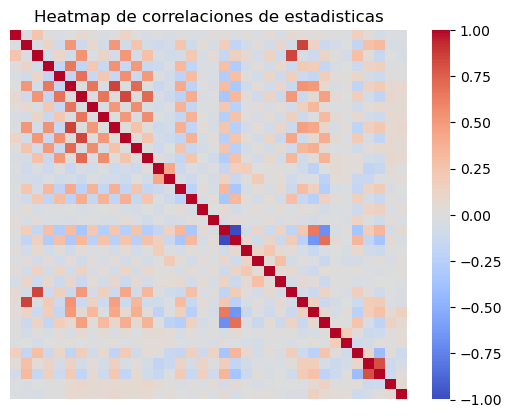

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_filtrado.corr()

sns.heatmap(corr, cmap='coolwarm', annot = False, xticklabels=False, yticklabels=False)
plt.title('Heatmap de correlaciones de estadisticas')
plt.show()

In [18]:
target_corr = corr['resultado'][(corr['resultado'] > 0.05) | (corr['resultado'] < -0.05)]

In [19]:
target_corr

resultado                 1.000000
shots_on_goal_away        0.250380
total_shots_away          0.075284
shots_insidebox_away      0.127434
red_cards_away           -0.051621
goalkeeper_saves_local    0.058156
odd_1                     0.161175
odd_2                    -0.059482
Name: resultado, dtype: float64

In [27]:
len(df_filtrado['resultado'])

5337

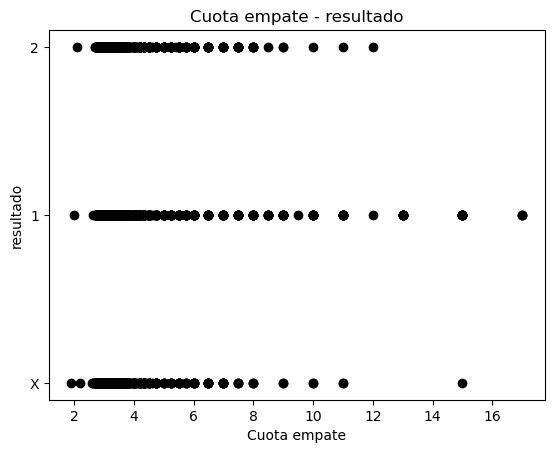

In [24]:
plt.scatter(df_filtrado['odd_x'], df_filtrado['resultado'], color='k')

# Configura los títulos y etiquetas de los ejes
plt.yticks([0, 1, 2], ['X', '1', '2'])
plt.title("Cuota empate - resultado")
plt.xlabel("Cuota empate")
plt.ylabel("resultado")

# Muestra el gráfico
plt.show()

In [28]:
df_reducido = df_filtrado.loc[df_filtrado['odd_x'] <= 6]

In [31]:
corr = df_reducido.corr()

In [33]:
target_corr = corr['resultado'][(corr['resultado'] > 0.05) | (corr['resultado'] < -0.05)]
target_corr

resultado                 1.000000
shots_on_goal_away        0.247203
total_shots_away          0.079159
shots_insidebox_away      0.130897
red_cards_away           -0.051837
goalkeeper_saves_local    0.053449
odd_1                     0.156144
odd_x                     0.055373
odd_2                    -0.094406
Name: resultado, dtype: float64

In [45]:
#Dividimos en los datos de entrenamiento y la clasificación de los datos de entrenamiento que usaremos para entrenar el modelo
X = df_final.drop(['index', 'fixture_id','resultado', 'goles_local', 'goles_visitante','goles_descanso_local','goles_descanso_visitante','fecha_timestamp','HomeTeam','AwayTeam'], axis=1)
y = df_final['resultado']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Pipeline para codificar la columna 'arbitro' con OneHotEncoder
arbitro_pipeline = Pipeline([
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

# Pipeline para codificar la columna 'estadio' con TargetEncoder
estadio_pipeline = Pipeline([
    ('target', TargetEncoder())
])

# ColumnTransformer para aplicar los pipelines a las columnas correspondientes
preprocessor = ColumnTransformer([
    ('arbitro', arbitro_pipeline, ['arbitro']),
    ('estadio', estadio_pipeline, ['estadio']),
    ], remainder = "passthrough")

# Pipeline final con el preprocesamiento y el modelo RandomForestClassifier
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA()),
    ('xgb', xgb.XGBClassifier())
])

xgb_param = {
'pca__n_components': [30],
'xgb__n_estimators': [700],
'xgb__learning_rate': [0.1],
'xgb__max_depth': [27],
'xgb__subsample': [0.5],
'xgb__colsample_bytree': [0.6],
'xgb__min_child_weight': [2],
'xgb__gamma': [0]
}

gs_xgb = GridSearchCV(
                        pipeline_xgb,
                        xgb_param,
                        cv=3,
                        scoring="accuracy",
                        verbose=1,
                        n_jobs=-1
                    )

modelo = gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [46]:
print('Best params: ', modelo.best_params_)
print('Best model: ', modelo.best_estimator_)
y_pred_xgb = modelo.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

Best params:  {'pca__n_components': 30, 'xgb__colsample_bytree': 0.6, 'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 27, 'xgb__min_child_weight': 2, 'xgb__n_estimators': 700, 'xgb__subsample': 0.5}
Best model:  Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('arbitro',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['arbitro']),
                                                 ('estadio',
                                                  Pipeline(steps=[('target',
                                                                   TargetEncoder())]),
                                                 

In [47]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.72      0.64      0.67       305
           1       0.87      0.91      0.89       500
           2       0.81      0.84      0.82       263

    accuracy                           0.82      1068
   macro avg       0.80      0.80      0.80      1068
weighted avg       0.81      0.82      0.81      1068



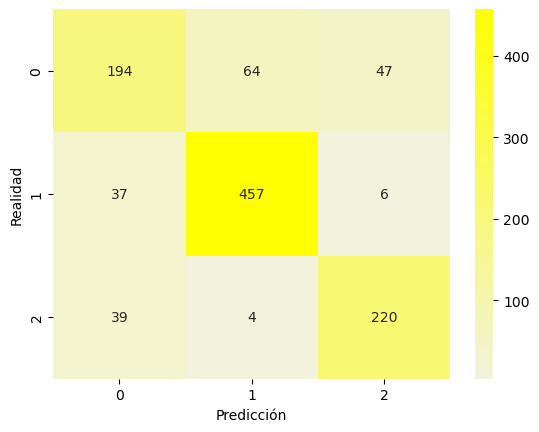

In [49]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True,fmt='g', cmap=sns.light_palette("yellow", as_cmap=True))
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

In [44]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       318
           1       1.00      1.00      1.00       490
           2       1.00      1.00      1.00       260

    accuracy                           1.00      1068
   macro avg       1.00      1.00      1.00      1068
weighted avg       1.00      1.00      1.00      1068

